In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
importlib.reload(LSTM)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


kernel = Matern(length_scale = [1,1],length_scale_bounds="fixed")
kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
+ WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point



      N   T  MSE  STD
0   174  37  0.0  0.0
1   192   9  0.0  0.0
2    19   5  0.0  0.0
3   133  31  0.0  0.0
4    90  32  0.0  0.0
5     6  12  0.0  0.0
6   133   4  0.0  0.0
7    36   6  0.0  0.0
8    72  29  0.0  0.0
9    60  24  0.0  0.0
10  113  27  0.0  0.0
11   41   8  0.0  0.0
12   10  45  0.0  0.0
13   75  47  0.0  0.0
14   73  31  0.0  0.0
{'epochs': 600, 'reps': 10, 'proc': 3, 'Searches': 10, 'Y': 'fch4', 'N_Max': 200, 'T_Max': 48}


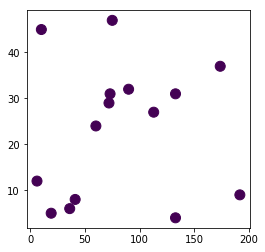

In [2]:
FillVar = 'fch4'
Runs,params = LSTM.Params('Full',FillVar,MP=True)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure(figsize = (4,4))
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [3]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(LSTM.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
         'VWC','Active Layer','Rain','Water Table']

# FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm']

Time = time.time()
Path = 'FilteredData2018-04-04.csv'

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time.copy()#*1.0
    X = RST.X_time.copy()#*1.0
    X_fill = RST.X_ftime.copy()
    MSE = []
    STD = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    FillVarName = 'Fch4'
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
        plt.figure(figsize=(5,5))
        plt.plot(RST.Master['Fch4'],color='red')
#         plt.plot(RST.Master['fch4'],color='grey')
        plt.plot(RST.Master['TempFill'],color='blue',alpha=.5)  # This works
        
        yl = plt.ylim()
#         plt.xlim(yl[0],yl[1])
        plt.grid()
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))

print(Runs)

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


Finisehed Run  0
Finisehed Run  1
Finisehed Run  2
Finisehed Run  3
Finisehed Run  4
Finisehed Run  5
Finisehed Run  6
Finisehed Run  7
Finisehed Run  8
Finisehed Run  9
Finisehed Run  10
Finisehed Run  11
Finisehed Run  12
Finisehed Run  13
Finisehed Run  14
      N   T       MSE       STD
0   174  37  0.636823  0.116496
1   192   9  0.596221  0.111915
2    19   5  0.598236  0.079293
3   133  31  0.624047  0.151811
4    90  32  0.622004  0.093687
5     6  12  0.620063  0.122565
6   133   4  0.561074  0.173997
7    36   6  0.555922  0.082009
8    72  29  0.661282  0.109355
9    60  24  0.618177  0.174274
10  113  27  0.669813  0.108769
11   41   8  0.559881  0.065969
12   10  45  0.750827  0.179133
13   75  47  0.622265  0.105955
14   73  31  0.622065  0.154524


In [4]:

for i in range(params['Searches']):
#     kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
    
    next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
        if N < params['N_Min'] or N > params['N_Max']:
            N -= int(o*np.cos(o*np.pi))
        if o > 5:
            T += 1
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    params['T'] = T
    params['N'] = N
    
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
print(Runs)
Optimum = Runs[Runs['MSE'] == Runs['MSE'].min()]
print('Optimum:')
print(Optimum)

[ 200.    0.]
200 0
[ 200.    0.]
Adjust!
199 0
[ 200.    0.]
Adjust!
Adjust!
201 0
[ 200.    0.]
Adjust!
Adjust!
Adjust!
198 0
[ 1.  0.]
1 0
[ 1.  0.]
Adjust!
0 0
[ 200.    0.]
Adjust!
Adjust!
Adjust!
Adjust!
202 0
[ 1.  0.]
Adjust!
Adjust!
2 0


Using TensorFlow backend.
Using TensorFlow backend.


[ 200.    0.]
Adjust!
Adjust!
Adjust!
Adjust!
Adjust!
197 0
[ 1.  0.]
Adjust!
Adjust!
Adjust!
-1 0


Using TensorFlow backend.


         MSE    N       STD   T
0   0.622036   -1  0.152847   0
1   0.621472    0  0.152992   0
2   0.621693    1  0.153206   0
3   0.622476    2  0.152965   0
4   0.620063    6  0.122565  12
5   0.750827   10  0.179133  45
6   0.598236   19  0.079293   5
7   0.555922   36  0.082009   6
8   0.559881   41  0.065969   8
9   0.618177   60  0.174274  24
10  0.661282   72  0.109355  29
11  0.622065   73  0.154524  31
12  0.622265   75  0.105955  47
13  0.622004   90  0.093687  32
14  0.669813  113  0.108769  27
15  0.561074  133  0.173997   4
16  0.624047  133  0.151811  31
17  0.636823  174  0.116496  37
18  0.596221  192  0.111915   9
19  0.621869  197  0.153437   0
20  0.621740  198  0.153438   0
21  0.622154  199  0.153029   0
22  0.625512  200  0.156784   0
23  0.624175  201  0.157841   0
24  0.624353  202  0.157430   0
Optimum:
        MSE   N       STD  T
7  0.555922  36  0.082009  6


['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Level:  1

['Wind Spd']

['air pressure']

['Ta']

['PPFD']

['Ts 2.5 cm']

['Ts 15 cm']

['VWC']

['Active Layer']

['Rain']

['Water Table']
Best:
['PPFD'] 0.855233270519
Level:  2

['Wind Spd', 'PPFD']

['air pressure', 'PPFD']

['Ta', 'PPFD']

['PPFD', 'Ts 2.5 cm']

['PPFD', 'Ts 15 cm']

['PPFD', 'VWC']

['PPFD', 'Active Layer']

['PPFD', 'Rain']

['PPFD', 'Water Table']


Using TensorFlow backend.


Best:
['PPFD', 'Active Layer'] 0.753054099617
Level:  3

['Wind Spd', 'PPFD', 'Active Layer']


Using TensorFlow backend.



['air pressure', 'PPFD', 'Active Layer']


Using TensorFlow backend.



['Ta', 'PPFD', 'Active Layer']

['PPFD', 'Ts 2.5 cm', 'Active Layer']

['PPFD', 'Ts 15 cm', 'Active Layer']

['PPFD', 'VWC', 'Active Layer']

['PPFD', 'Active Layer', 'Rain']

['PPFD', 'Active Layer', 'Water Table']
Best:
['air pressure', 'PPFD', 'Active Layer'] 0.62054815147
Level:  4

['Wind Spd', 'air pressure', 'PPFD', 'Active Layer']

['air pressure', 'Ta', 'PPFD', 'Active Layer']

['air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer']

['air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer']

['air pressure', 'PPFD', 'VWC', 'Active Layer']

['air pressure', 'PPFD', 'Active Layer', 'Rain']

['air pressure', 'PPFD', 'Active Layer', 'Water Table']
Best:
['air pressure', 'PPFD', 'Active Layer', 'Water Table'] 0.575809483971
Level:  5

['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Water Table']

['air pressure', 'Ta', 'PPFD', 'Active Layer', 'Water Table']

['air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Water Table']

['air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer', 'W

Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Water Table']


Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'VWC', 'Active Layer', 'Water Table']


Using TensorFlow backend.



['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'PPFD', 'Active Layer', 'Rain', 'Water Table'] 0.540685489829
Level:  7

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Active Layer', 'Rain', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Active Layer', 'Rain', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer', 'Rain', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'Active Layer', 'Rain', 'Water Table'] 0.543158212809
Level:  8

['Wind Spd', 'air pressure', 'Ta', 'PPFD', 'Ts 15 cm', 'Active Layer', 'Rain', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 2.5 cm', 'Ts 15 cm', 'Active Layer', 'Rain', 'Water Table']

['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'VWC', 'Active Layer', 'Rain', 'Water Table']
Best:
['Wind Spd', 'air pressure', 'PPFD', 'Ts 15 cm', 'VW

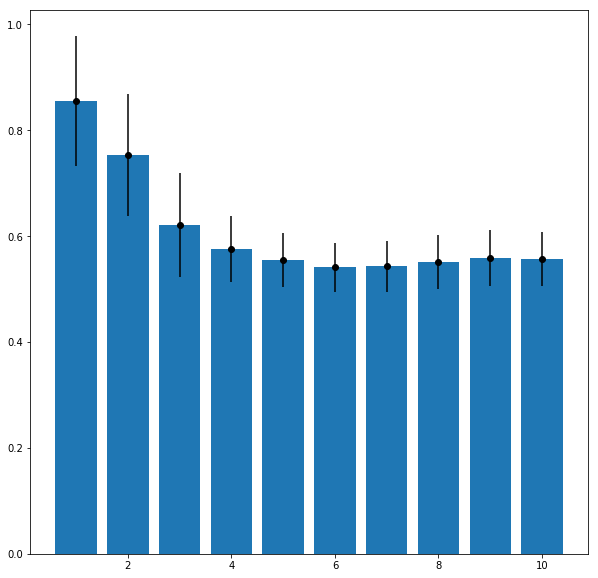

In [5]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor == None:
            Models.append(c)
        else:
            if set(factor).issubset(set(c)):
#             if factor in c:
                Models.append(c)
    return(Models)
params['T']=Optimum['T'].values[0]
params['N']=Optimum['N'].values[0]


Results = RunReps(FullModel,params,pool,FullReturn=True)
FullScore = Results[0]
Data = Results[1]


BestMSE = []
BestSTD = []
idx = []
BestModels = []

print(FullModel)

for i in range(1,len(FullModel)+1):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     for model in Models:
    Score = []
    STD = []
    for model in Models:
        print()
        print(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        Score.append(MSE.mean())
        STD.append(MSE.std())
        Data['Model: '+'+'.join(model)] = Results[1]
#         plt.figure()
#         plt.plot(Results[1])
#         plt.title('+'.join(model))
    Score = np.asanyarray(Score)
    STD = np.asanyarray(STD)
#         print(Score)
    Best = Models[np.where(Score == Score.min())[0][0]]
    BestModels.append(Best)
    BestMSE.append(Score.min())
    BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
    idx.append(i)
    print('Best:')
    print(Best,Score.min())
BestModels = np.asanyarray(BestModels)
BestMSE = np.asanyarray(BestMSE)
BestSTD = np.asanyarray(BestSTD)
idx = np.asanyarray(idx)
BestSE = BestSTD/(params['reps']**.5)
BestCI = BestSE*1.96
plt.figure(figsize=(10,10))
plt.bar(idx,BestMSE)
plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

d = {'Models':BestModels,'MSE':BestMSE,'STD':BestMSE}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary.csv')
print(Stats)

Data.to_csv('GapFilled'+FillVar+'.csv')

In [6]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        

5650.247350931168


In [7]:

d = {'Models':BestModels,'MSE':BestMSE,'STD':BestMSE}
Stats = pd.DataFrame(index=idx,data=d)
Stats.to_csv('GapFillingSummary.csv')
print(Stats)

         MSE                                             Models       STD
1   0.855233                                             [PPFD]  0.855233
2   0.753054                               [PPFD, Active Layer]  0.753054
3   0.620548                 [air pressure, PPFD, Active Layer]  0.620548
4   0.575809    [air pressure, PPFD, Active Layer, Water Table]  0.575809
5   0.555539  [Wind Spd, air pressure, PPFD, Active Layer, W...  0.555539
6   0.540685  [Wind Spd, air pressure, PPFD, Active Layer, R...  0.540685
7   0.543158  [Wind Spd, air pressure, PPFD, Ts 15 cm, Activ...  0.543158
8   0.551564  [Wind Spd, air pressure, PPFD, Ts 15 cm, VWC, ...  0.551564
9   0.558820  [Wind Spd, air pressure, Ta, PPFD, Ts 15 cm, V...  0.558820
10  0.556362  [Wind Spd, air pressure, Ta, PPFD, Ts 2.5 cm, ...  0.556362


In [8]:
print(Score)

[ 0.55636238]
